In [1]:
from BCM_lensing.halo import Halo
from BCM_lensing.component import CG, BG, EG, RDM
from BCM_lensing.utils import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nbodykit.lab import *
from nbodykit.cosmology import Planck15
from scipy.interpolate import interp1d

import illustris_python as il

import warnings; warnings.simplefilter('ignore')

In [2]:
# Plot params
SMALL_SIZE = 12
L_SIZE     = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=L_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=L_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=L_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Illustris Data 
basePath = '../Illustris-3-Dark/output'

subgroupFields = [ 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloMass','SubhaloParent', 'SubhaloPos' ]
groupFields = [ 'GroupFirstSub', 'GroupLen', 'GroupMass','GroupNsubs', 'Group_M_Crit200','Group_R_Crit200', 'GroupPos', 'Group_R_Mean200']

subgroups = il.groupcat.loadSubhalos(basePath,135, fields=subgroupFields)
groups = il.groupcat.loadHalos(basePath,135, fields=groupFields)

groupPos = groups.pop('GroupPos')
subgroupPos = subgroups.pop('SubhaloPos')

group_df = pd.DataFrame(groups)
subgroup_df = pd.DataFrame(subgroups)

group_df['GroupMass']  = group_df['GroupMass']
group_df['Group_M_Crit200']  = group_df['Group_M_Crit200']
group_df['Group_R_Crit200']  = group_df['Group_R_Crit200']

In [4]:
M1 = 8.63e1
M_c = 3.3e3
beta = .12
eta=.54
omega_b=Planck15.Omega0_b
omega_m=Planck15.Omega0_m

halo_num=110
particle_mass = 4.8e-2

# Building a halo

In [70]:
# NEW CARTESIAN DRIVER

# Build a halo object
halo = Halo(110, group_df, groupPos, subgroupPos)

In [71]:
# You can choose the maximum r_value  as mult * r_200
mult = 12

# Also the resolution of the fittings/ number of radial shells
halo.resolution=20

halo.run_density(mult)

# Fit NFW parameters
halo.nfw_fit()

In [72]:
halo.c

7.943282347242816

In [7]:
def plot_fit(hd, ri, popt, r_200, rho_crit=Planck15.rho_crit(0), save=False):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True, gridspec_kw={'hspace':.1, 'height_ratios':[3, 1]})
    ax1.loglog(ri/r_200, hd, '.', label='Data')
    ax1.loglog(ri/r_200, halo.nfw_density(ri, *popt, clipped=True), label='NFW_fit')
    ax2.semilogx(ri/r_200, hd/halo.nfw_density(ri, *popt, clipped=True), label='Error')
    ax1.legend(fontsize=(16))
    ax2.set_xlabel(r'$r/r_{200}$', fontsize=18)
    ax1.set_ylabel(r'$\dfrac{\log(\rho)}{\log(\rho_{c})}$', fontsize=18)
    ax2.set_ylabel(r'$\dfrac{\rho_{data}}{\rho_{NFW}}$', fontsize=18);
    plt.tight_layout()
        

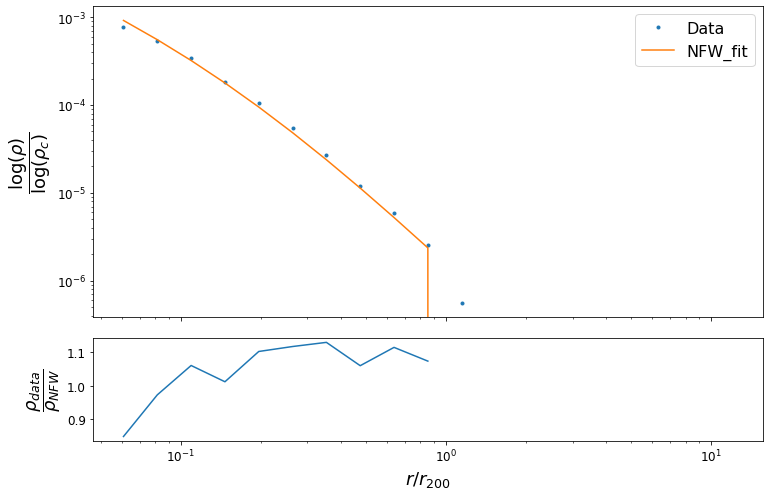

In [8]:
plot_fit(halo.halo_density, halo.ri[1:], [halo.c, halo.rho_s], halo.r_200)

# Looking at corrections

## Density Functions

In [9]:
# We initialize each component using the halo quantities
cg = CG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
bg = BG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
eg = EG(halo.r_200, halo.m_200, halo.c, halo.rho_s)

# RDM is dependant on the previous three quantities
rdm = RDM(cg, bg, eg)

#Compute the xi factor
xi = rdm.run_xi(halo.ri, halo.masses)

# Compute the densities 
cg_d = cg.density(halo.ri)
bg_d = bg.density(halo.ri)
eg_d = eg.density(halo.ri)
rdm_d = rdm.density(halo.ri, halo.masses, xi)

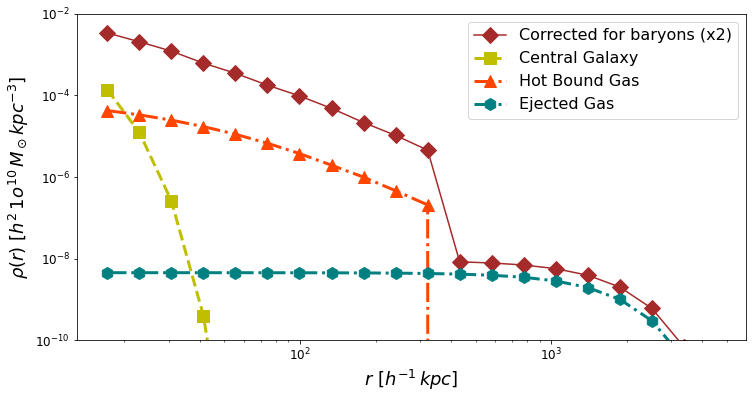

In [10]:
plt.figure(figsize=(12, 6))
plt.loglog(halo.ri, 2 * (rdm_d + cg_d + eg_d +bg_d), marker='D', c='brown', label='Corrected for baryons (x2)', markersize=12)
plt.loglog(halo.ri, cg_d, marker='s', color='y',  linestyle='--', linewidth=3, label='Central Galaxy', markersize=12)
plt.loglog(halo.ri, bg_d, marker='^', c='orangered',  linestyle='-.', linewidth=3, label='Hot Bound Gas', markersize=12)
plt.loglog(halo.ri, eg_d, marker='h', c='teal', linestyle='-.', linewidth=3, label='Ejected Gas', markersize=12)


plt.legend(fontsize=16)
plt.ylim(1e-10, 1e-2)
# plt.xlim(4e-2)
plt.xlabel(r'$r \,\,[h^{-1}\,kpc]$', fontsize=18)
plt.ylabel(r'$\rho(r)\,\, [h^{2}\,1o^{10}\,M_\odot kpc^{-3}]$', fontsize=18);

## Mass functions

In [11]:
# Easy Peesy Lemon Squeezy
cg_m = cg.Mass(halo.ri)
bg_m = bg.Mass(halo.ri)
eg_m = eg.Mass(halo.ri)
rdm_m = rdm.Mass(halo.ri, halo.masses, xi)

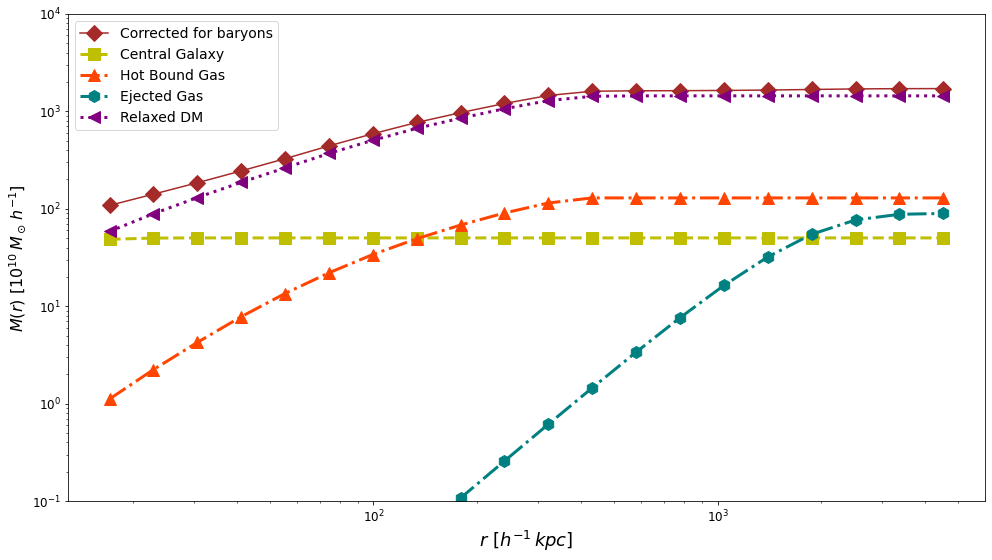

In [12]:
plt.figure(figsize=(14, 8))
plt.loglog(halo.ri, (cg_m+bg_m+eg_m+rdm_m), marker='D', c='brown', label='Corrected for baryons', markersize=12)
plt.loglog(halo.ri, cg_m, marker='s', color='y',  linestyle='--', linewidth=3, label='Central Galaxy', markersize=12)
plt.loglog(halo.ri, bg_m, marker='^', c='orangered',  linestyle='-.', linewidth=3, label='Hot Bound Gas', markersize=12)
plt.loglog(halo.ri, eg_m, marker='h', c='teal', linestyle='-.', linewidth=3, label='Ejected Gas', markersize=12)
plt.loglog(halo.ri, rdm_m,linestyle=':',lw=3,  marker='<', c='purple', label='Relaxed DM', markersize=12)


plt.legend()
plt.ylim(1e-1, 1e4)
# plt.xlim(4e-2, 10)
plt.xlabel(r'$r \,\,[h^{-1}\,kpc]$', fontsize=18)
plt.ylabel(r'$M(r)\,\, [10^{10}\,M_\odot\,h^{-1}]$');

plt.tight_layout()


# Putting it all together

In [13]:
halo.subhalo_dm.keys()

dict_keys(['count', 'Coordinates', 'ParticleIDs', 'Potential', 'Velocities'])

In [25]:
# Build a halo object
halo = Halo(halo_num, group_df, groupPos, subgroupPos, resolution=40, basePath=basePath)

halo.run_density(mult=12)

# Fit NFW parameters
halo.nfw_fit()

# Remember the order of r
i = np.argsort(halo.subhalo_dm_r_over)
r_sorted = halo.subhalo_dm_r_over[i]

# Compute the true mass profile
true_masses = (np.arange(len(r_sorted))+1) * halo.particle_mass

# Generate the BCM components
cg = CG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
bg = BG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
eg = EG(halo.r_200, halo.m_200, halo.c, halo.rho_s)
rdm = RDM(cg, bg, eg)

# Compute the relaxation parameter xi for each r
xi = rdm.run_xi(halo.ri, halo.masses)
rdm.build_MassFunc(halo.ri, halo.masses)

# Calculate the BCM mass profile
M_BCM = cg.Mass(halo.ri) + bg.Mass(halo.ri) + eg.Mass(halo.ri) + rdm.Mass(halo.ri, halo.masses, xi)


# Interpolate the BCM to each of the particle r's
M_BCM_interp = interp1d(M_BCM, halo.ri, fill_value='extrapolate', assume_sorted=True)


# Invert to find r_BCM
r_BCM = M_BCM_interp(true_masses)

# Compute the difference in the radii
dr = r_BCM - r_sorted

# Dont adjust the particles outside of r_200 or inside of 3epsilon
dr[r_sorted > halo.r_200] = 0
dr[r_sorted<halo.ri[0]] = 0

# Return to original order
res = np.empty(dr.shape)
res[i] = dr

# Apply corrections to full dm particle positions
dm = halo.dm['Coordinates']
delta = np.pad(res, (0, len(dm) - len(res)))
correction = ((halo.halo_dm_r + delta)/halo.halo_dm_r )[:, np.newaxis]

# Convert back to cartesian
new_cartesian =  correction * (dm - halo.sg_COM) + halo.sg_COM

phi_pos = dr.copy()
phi_neg = dr.copy()
phi_pos[dr<0] = 0
phi_neg[dr>0] = 0
phi_neg[dr<0] = np.abs(phi_neg[dr<0])


No handles with labels found to put in legend.


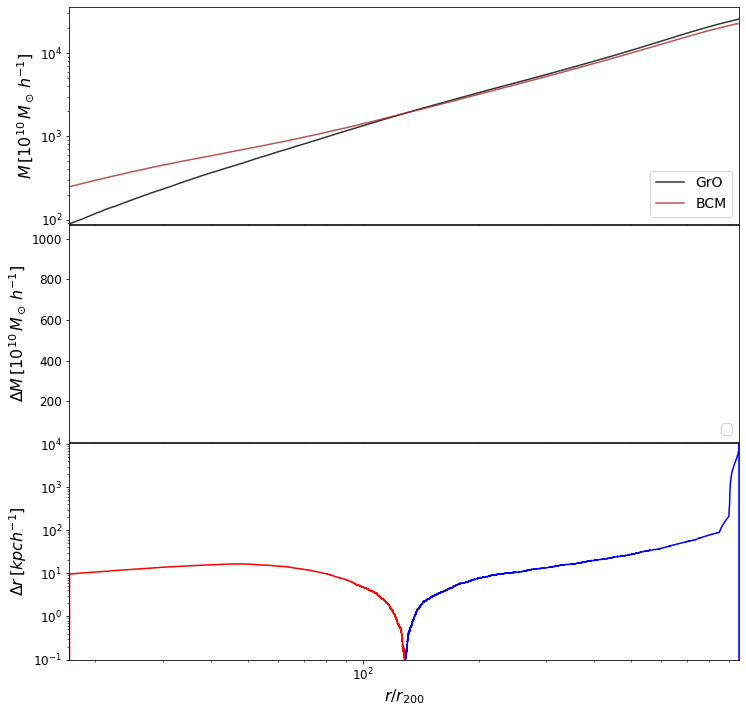

In [27]:
# PLOT CHECK
fig, axs = plt.subplots(nrows=3, figsize=(12, 12), sharex=True, gridspec_kw = {'hspace':.005})
r_sorted = np.array(r_sorted)
axs[0].loglog(r_sorted, true_masses, '-', markersize=.8, alpha=.8, c='k', label='GrO')
axs[0].loglog(halo.ri, M_BCM, '-', markersize=.8, alpha=.8, c='brown', label='BCM')
# diff =true_masses - M_BCM_total
# axs[1].loglog(r_sorted, diff, '-', c='blue', label='Positive Displacement')
# diff[diff>0] = 0
# diff[diff<0] = np.abs(diff[diff<0])
# axs[1].loglog(r_sorted, diff, '-', c='red', label='Negative displacement')
axs[2].loglog(r_sorted, phi_neg, '-', c='red')
axs[2].loglog(r_sorted, phi_pos, '-', c='blue')


# plt.loglog(halo.ri[1:], M_BCM[1:], ':')#, '-', markersize=.5, alpha=.8)
# plt.loglog(halo.ri[1:], M_NFW[1:], ':', )#, '-', markersize=.5, alpha=.8)
# axs[0].axvline(1, color='k', ls='--', lw=2, label=r'$r_{200}$')
# axs[1].axvline(1, color='k', ls='--', lw=2)
# axs[2].axvline(1, color='k', ls='--', lw=2)

axs[0].set_ylabel(r'$M\,[10^{10}\,M_\odot\,h^{-1}]$')
axs[1].set_ylabel(r'$\Delta M\,[10^{10}\,M_\odot\,h^{-1}]$')
axs[2].set_ylabel(r'$\Delta r \, [kpc h^{-1}]$')
axs[2].set_xlabel(r'$r/r_{200}$')

axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')







axs[0].set_xlim(halo.ri[0], halo.r_200)
axs[0].set_ylim(np.max(np.array(true_masses)[r_sorted<halo.ri[0]]), np.max(halo.masses)+10000)
axs[1].set_ylim(1e-2, np.max(diff)+1000)
axs[2].set_ylim(1e-1, np.max(phi_pos)+100)


# labels = [r'$3\epsilon$',r'$r_{ej}$' , r'$r_s$', r'$r_{200}/\sqrt{5}$', r'$r_{200}$']
# ts = [3*5.7, r_ej(r_200, eta), r_200/popt[0], 1/np.sqrt(5), 1]
# for ax in axs:
#     for t, label in zip(ts, labels):
#         ax.axvline(t, c='k', ls=':')
        
#         axs[1].text(t, 1, label, fontsize=16)
        


# axs[2].set_xticks(ts)

# axs[2].set_xticklabels(labels)
plt.tight_layout()


In [28]:
from nbodykit.lab import *

In [56]:
power_path = '/Users/maxlee/BCM Learning/power_files/snapdir_135/BCM_coordinates_M1-86.3_MC-3300.0_eta-0.540_beta-0.120/power/'

cg_p =FFTPower.load(power_path+'CGmap_Nmesh455_p.json').power
bg_p =FFTPower.load(power_path+'BGmap_Nmesh455_p.json').power
eg_p =FFTPower.load(power_path+'EGmap_Nmesh455_p.json').power
rdm_p=FFTPower.load(power_path+'RDMmap_Nmesh455_p.json').power
bcm_p=FFTPower.load(power_path+'BCMmap_Nmesh455_p.json').power
dm_p =FFTPower.load(power_path+'DMOmap_Nmesh455_p.json').power



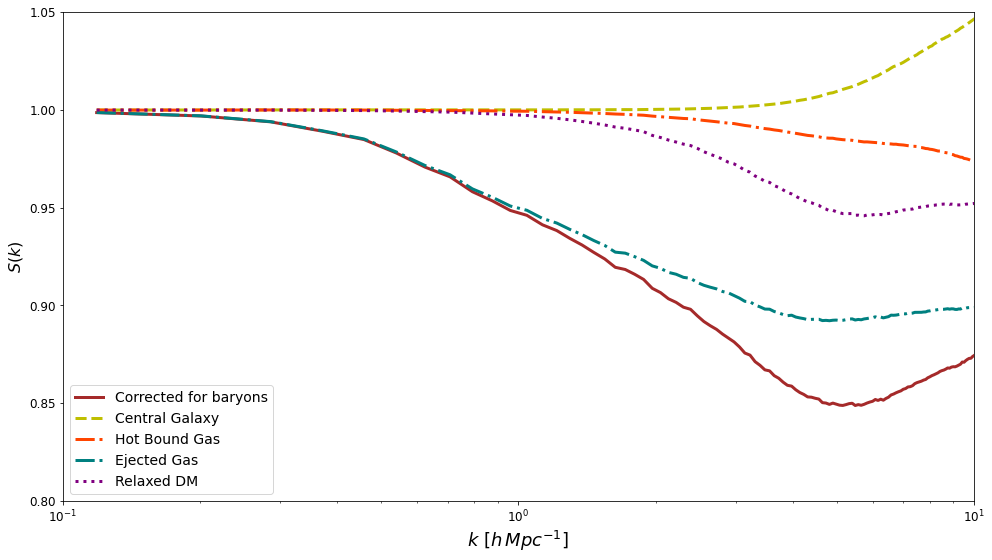

In [73]:
plt.figure(figsize=(14, 8))
plt.semilogx(dm_p['k'],bcm_p['power']/dm_p['power']  ,c='brown', linewidth=3, label='Corrected for baryons', markersize=12)
plt.semilogx(dm_p['k'],cg_p['power'] /dm_p['power']  ,color='y',  linestyle='--', linewidth=3, label='Central Galaxy', markersize=12)
plt.semilogx(dm_p['k'],bg_p['power'] /dm_p['power']  ,c='orangered',  linestyle='-.', linewidth=3, label='Hot Bound Gas', markersize=12)
plt.semilogx(dm_p['k'],eg_p['power'] /dm_p['power']  ,c='teal', linestyle='-.', linewidth=3, label='Ejected Gas', markersize=12)
plt.semilogx(dm_p['k'],rdm_p['power']/dm_p['power'] ,linestyle=':',lw=3, c='purple', label='Relaxed DM', markersize=12)


plt.legend()
plt.ylim(.8, 1.05)
# plt.axhline(.85)
plt.xlim(1e-1, 1e1)
plt.xlabel(r'$k \,\,[h\,Mpc^{-1}]$', fontsize=18)
plt.ylabel(r'$S(k)$');

plt.tight_layout()



In [51]:
(1-Planck15.Omega0_b/Planck15.Omega0_m)**2

0.7100917776210449

In [58]:
def test_gamma(c):
    num = (1+3 * c /np.sqrt(5)) * np.log(1 + c/np.sqrt(5))
    denom = (1+ c/np.sqrt(5)) * np.log(1+c/np.sqrt(5)) - c/np.sqrt(5)
    return num/denom

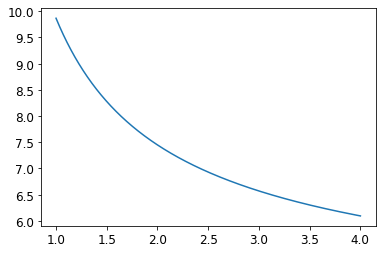

In [66]:
plt.figure()
plt.plot(np.linspace(1, 4, 1000), test_gamma(np.linspace(1, 4, 1000)))